### Use newsapi to collect all pieces of news about trade war and store them in jsons

In [1]:
import requests

import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt

pd.set_option('max_colwidth',10000)

%matplotlib inline

In [ ]:
# A function specifies search conditions and generates an API url
def generate_url(page,start,end):
    url = ('https://newsapi.org/v2/everything?'
       'q="trade war"&'
       'sources=["the-new-york-times","cnn","xinhua-net"]&'
       f'from={start}&'
       f'to={end}&'
       'sortBy=relevancy&'
       'pageSize=100&'
       f'page={page}&'
       'apiKey=fc8921bcf53e482ba461714a254c0d7c'
       )
    return url

In [ ]:
# A function takes in start and end dates of a time period,
# and first searchs for articles within that period 
# based on the condition specified in the API url,
# then writes the first 1000 articles of the searching result
# into a csv file.
def write_result(start,end):
    
    # Collect information about each article returned by the search
    # Store the information in a list of jsons
    result = []
    for i in range(1,11):
        response = requests.get(generate_url(i,start,end))
        result.extend(response.json()['articles'])       

    # Transport critical information of the article to a list of dictionaries
    col = ['title','description','content','url','publishedAt']
    df_dict = []
    for article in result:
        temp = {}
        for c in col:
            try: 
                temp[c] = article[c]
            except:
                temp[c] = np.nan
        temp['source'] = article['source']['name']
        df_dict.append(temp)
    
    # Convert the list of dicts into a pandas DataFrame
    df = pd.DataFrame(df_dict,columns=col.append('source'))
    
    # Write the DataFrame into a csv file
    st = ''.join(start.split('-')[1:])
    en = ''.join(end.split('-')[1:])
    df.to_csv(f'data/article_info({st}-{en}).csv')
    
    return df

In [ ]:
df1 = write_result('2018-11-04','2018-11-08')
df2 = write_result('2018-10-30','2018-11-03')
df3 = write_result('2018-10-25','2018-10-29')
df4 = write_result('2018-10-20','2018-10-24')
df5 = write_result('2018-10-15','2018-10-19')
df6 = write_result('2018-10-10','2018-10-14')

In [ ]:
df_list = [df1,df2,df3,df4,df5,df6]
df=pd.concat(df_list,ignore_index=True)

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df.fillna('',inplace=True)

In [ ]:
df.isnull().sum()

In [ ]:
df.to_csv('data/article_info_6000.csv')

### Word Preprocessing and Vectorizing

In [1]:
import requests

import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt

pd.set_option('max_colwidth',10000)

%matplotlib inline

In [2]:
df = pd.read_csv('data/article_info_6000.csv')

In [3]:
import nltk
from nltk.util import ngrams

from textblob import TextBlob

from collections import Counter
from operator import itemgetter

from nltk.corpus import stopwords

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
import re
import string

#### Documents Cleanup

In [6]:
def cleanup_doc(doc):
    # Replace punctuations with a white space
    doc = re.sub('[%s]' % re.escape(string.punctuation), ' ', doc)
    # Remove all words containing digits
    doc = re.sub('\w*\d\w*', ' ', doc)
    # Keep US as a special term
    doc = re.sub('U.S.', 'US', doc)
    # Change all words into lowercases
    doc = doc.lower()
    # Remove all non English characters
    doc = ' '.join(w for w in nltk.word_tokenize(doc) if w.isalpha())
    # Remove stopwords
    stop = stopwords.words('english')
    stop = set(stop)
    doc = ' '.join(w for w in nltk.word_tokenize(doc) if w not in stop)
    
    return doc

In [7]:
def super_clean(collection):
    clean = []
    for c in collection:
        clean.append(cleanup_doc(c))
    return clean

In [8]:
content = df.title+' '+df.description

In [9]:
content.dropna(inplace=True)

In [10]:
content = super_clean(content)

In [11]:
def find_top_bigrams(collection, num):
    counter = Counter()

    n = 2
    for c in collection:
        words = TextBlob(c).words
        bigrams = ngrams(words, n)
        counter += Counter(bigrams)

    res = []
    for phrase, count in counter.most_common(num):
        res_tuple = (" ".join(phrase), count)
        res.append(res_tuple)
    
    return res

In [12]:
top30 = set(find_top_bigrams(content, 30))
top60 = set(find_top_bigrams(content, 60))
top90 = set(find_top_bigrams(content, 90))

In [13]:
list(top60.difference(top30))

[('us treasury', 83),
 ('first time', 83),
 ('states china', 91),
 ('sino us', 90),
 ('trade deal', 75),
 ('us stocks', 106),
 ('global financial', 71),
 ('central bank', 90),
 ('trump xi', 93),
 ('per cent', 105),
 ('last week', 75),
 ('yahoo news', 96),
 ('china us', 109),
 ('reuters china', 74),
 ('emerging markets', 71),
 ('federal reserve', 79),
 ('amid trade', 87),
 ('war fears', 71),
 ('global stocks', 84),
 ('gold prices', 74),
 ('global growth', 87),
 ('china economy', 85),
 ('tech stocks', 75),
 ('financial crisis', 100),
 ('saudi arabia', 103),
 ('asian stocks', 89),
 ('appeared first', 84),
 ('escalating trade', 96),
 ('us dollar', 80),
 ('global trade', 71)]

In [14]:
list(top90.difference(top60))

[('trade wars', 59),
 ('next month', 69),
 ('last month', 51),
 ('china united', 60),
 ('us tariffs', 70),
 ('iran sanctions', 53),
 ('month low', 59),
 ('gdp growth', 57),
 ('nov reuters', 52),
 ('us stock', 70),
 ('next year', 68),
 ('year low', 51),
 ('chinese president', 68),
 ('china says', 58),
 ('free trade', 52),
 ('global economy', 56),
 ('china economic', 67),
 ('dow jones', 62),
 ('us economy', 68),
 ('york times', 60),
 ('need know', 64),
 ('us midterm', 68),
 ('trump tariffs', 60),
 ('growth slows', 50),
 ('trade talks', 54),
 ('us sanctions', 53),
 ('wall st', 67),
 ('shinzo abe', 55),
 ('washington post', 70),
 ('prime minister', 59)]

In [15]:
def fit_stuff(doc,cv,ngram,max_df,min_df):
    cv.ngram_range=(1,ngram)
    cv.max_df = max_df
    cv.min_df = min_df
    x = cv.fit_transform(doc).toarray()
    x = pd.DataFrame(x, columns=cv.get_feature_names())
    return x

In [16]:
X_tfidf = fit_stuff(content,TfidfVectorizer(),2,0.2,2)
X_tfidf.shape

(5916, 26902)

In [17]:
X_cv = fit_stuff(content,CountVectorizer(),2,0.2,2)
X_cv.shape

(5916, 26902)

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train_cv, X_test_cv = train_test_split(X_cv, test_size=0.3, random_state=42)

In [20]:
X_train_tfidf, X_test_tfidf = train_test_split(X_tfidf, test_size=0.3, random_state=42)

In [21]:
print(X_train_tfidf.shape,X_test_tfidf.shape)

(4141, 26902) (1775, 26902)


In [22]:
vocab = np.array(X_cv.columns)
counts = np.array(X_cv.sum(0))[0:,]
vocab[np.argsort(-counts)[:100]]

array(['trump', 'global', 'chinese', 'stocks', 'market', 'markets',
       'president', 'growth', 'us china', 'world', 'new', 'china trade',
       'economic', 'reuters', 'year', 'tariffs', 'economy', 'stock',
       'donald', 'donald trump', 'beijing', 'oil', 'wall', 'united',
       'investors', 'said', 'states', 'could', 'prices', 'says',
       'united states', 'shares', 'week', 'amid', 'month', 'street', 'xi',
       'wall street', 'since', 'news', 'asian', 'percent', 'two', 'asia',
       'first', 'president donald', 'thursday', 'dollar', 'earnings',
       'monday', 'friday', 'quarter', 'tuesday', 'tensions', 'business',
       'washington', 'day', 'third', 'higher', 'next', 'may', 'report',
       'wednesday', 'concerns', 'gold', 'october', 'top', 'last', 'tech',
       'bank', 'oct', 'years', 'billion', 'time', 'high', 'one',
       'financial', 'rising', 'companies', 'post', 'hit', 'september',
       'fears', 'back', 'japan', 'oil prices', 'sales', 'fell', 'demand',
       '

In [23]:
counts

array([8, 4, 4, ..., 2, 2, 2])

In [24]:
from collections import Counter

countfreq = np.array(Counter(counts).most_common()).T

In [25]:
countfreq

array([[    2,     3,     4,     5,     6,     7,     8,     9,    10,
           11,    12,    13,    15,    14,    18,    16,    19,    17,
           20,    21,    22,    24,    23,    27,    26,    28,    25,
           31,    29,    30,    33,    32,    36,    35,    39,    37,
           40,    38,    45,    34,    41,    47,    44,    51,    46,
           50,    55,    58,    42,    43,    54,    48,    74,    69,
           68,    49,    60,    57,    76,    70,    52,    73,    63,
           67,    61,    89,    64,    71,    56,    62,   105,    59,
           66,    83,    53,    97,    72,    75,    65,    87,   121,
          111,   103,    77,    79,    82,   125,   104,    98,    92,
          106,   138,   141,   108,    94,    90,   100,   112,   117,
          129,   161,   122,    78,   107,    88,    91,    84,   185,
          157,   109,   167,    95,   187,   228,   133,   150,   126,
          131,    96,   256,    86,    80,   186,   154,   195,   220,
      

In [26]:
[countfreq[0,:20]]

[array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 14, 18, 16, 19,
        17, 20, 21])]

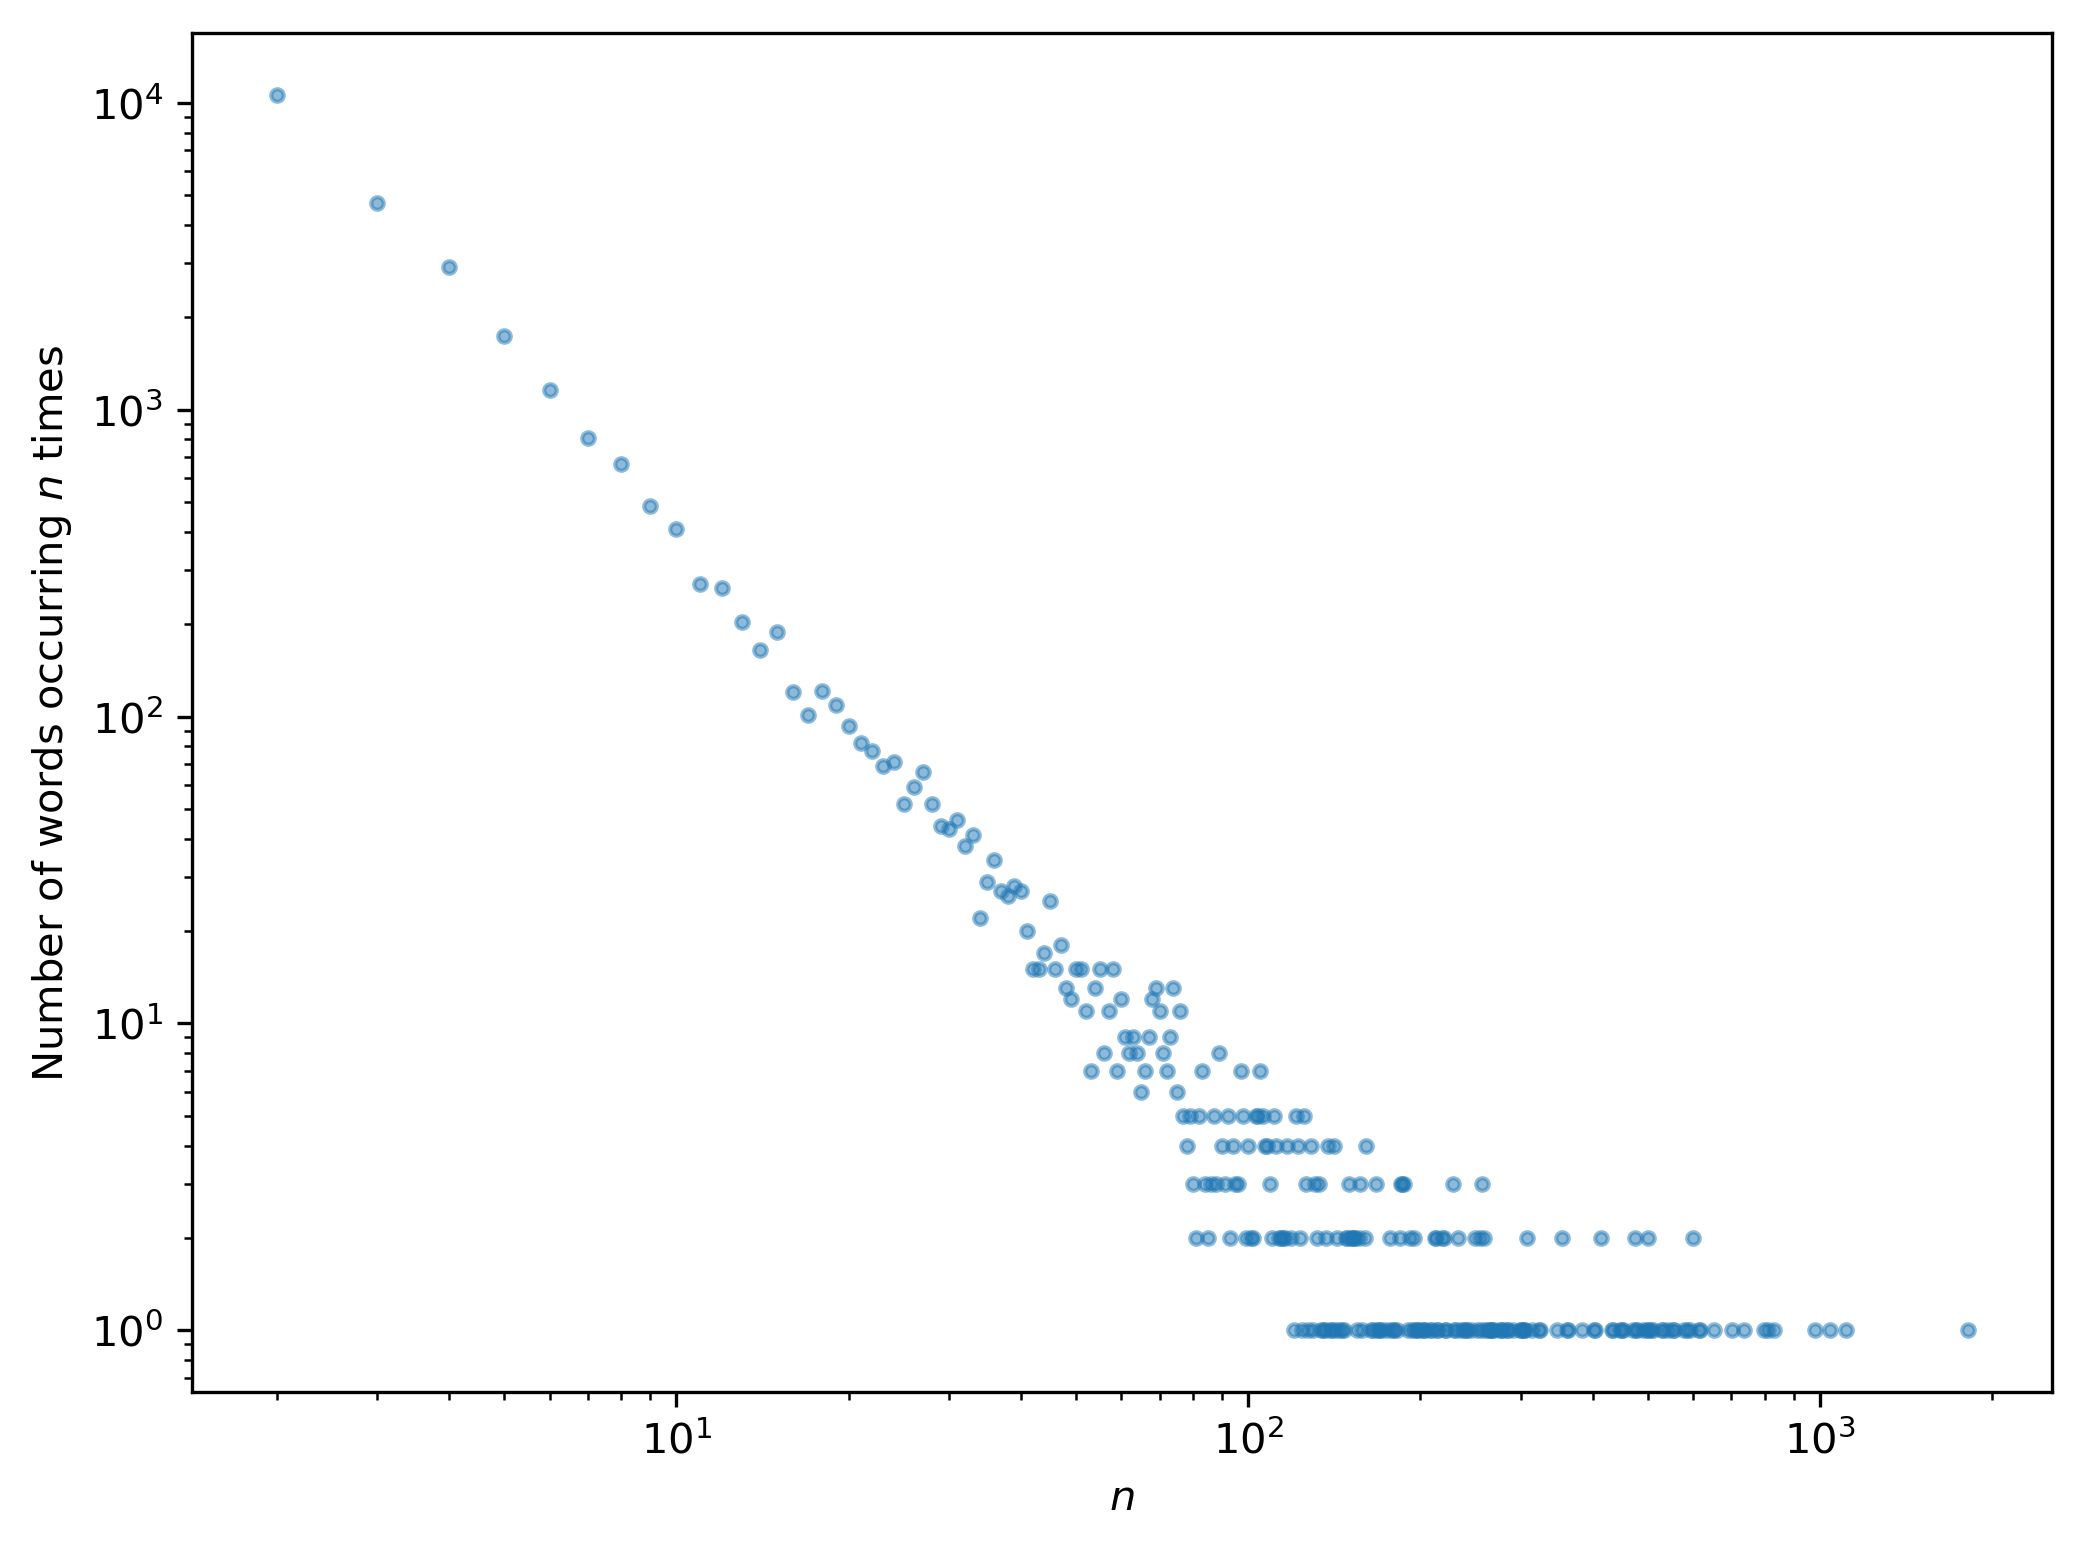

In [27]:
%config InlineBackend.figure_format = 'png'
plt.figure(dpi=300,figsize=(8,6))
plt.plot(*countfreq,'.',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$n$")
plt.ylabel("Number of words occurring $n$ times");

### LDA Dimension Reduction

In [28]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [29]:
n_components = 30

lda = LatentDirichletAllocation(n_components=n_components, 
                                learning_method='online',
                                learning_decay = 0.6,
                                batch_size = 256,
                                learning_offset=1024,
                                topic_word_prior = 0.005,
                                random_state=0)

lda.fit(X_cv)

LatentDirichletAllocation(batch_size=256, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.6,
             learning_method='online', learning_offset=1024,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=30, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=0.005,
             total_samples=1000000.0, verbose=0)

In [30]:
lda.perplexity(X_cv)

387549.02427362202

In [31]:
for topic in range(n_components):
    print(f"TOPIC {topic}")
    for j in np.argsort(-lda.components_,1)[topic,:10]:
        print(vocab[j])
    print()

TOPIC 0
jet
harley
davidson
harley davidson
model
airshow
fighter jet
fighter
flight
roaring

TOPIC 1
middle
class
middle class
goldman
investment
banking
sachs
asia
goldman sachs
investment banking

TOPIC 2
fund
global fund
avenir global
avenir
ended september
commentary
quarter ended
ended
fund commentary
dear

TOPIC 3
trump
president
chinese
donald
donald trump
ivanka
beijing
ivanka trump
says
adviser

TOPIC 4
profit
apple
yahoo
yahoo news
wto
panel
quarterly
reported
retaliation
news

TOPIC 5
jd
jd com
democrat
house
com
us house
richest
年最大危機
allies
trump trade

TOPIC 6
rupee
internet
paise
dollar
indian rupee
farmers
internet conference
conference
soybeans
beans

TOPIC 7
kong
hong kong
hong
city
world report
us news
news world
lawmakers
news
leader

TOPIC 8
asian
asian shares
brexit
week
shares
sterling
hopes
pound
two
monday

TOPIC 9
risky
correction
correction wall
flirts
risky investments
investments nasdaq
nasdaq flirts
flirts correction
view us
looked like

TOPIC 10
election

In [32]:
cv = CountVectorizer(#tokenizer=my_tokenizer,
                             strip_accents='ascii',
                                max_df=0.2, 
                                min_df=2,
                                ngram_range=(1,2),
#                                 binary=True
                               )

In [34]:
from pyLDAvis import sklearn
viz=pyLDAvis.sklearn.prepare(lda, X_cv, cv)
pyLDAvis.display(viz)

NameError: name 'pyLDAvis' is not defined

### Sentiment Analysis

### Recommedation System for Readers

### Visualization

In [ ]:
plt.bar(phrase_count.keys(),phrase_count.values())